# Neural Network from Scratch in Python

In [1]:
from dataclasses import dataclass
from abc import ABC, abstractmethod
import numpy as np
from typing import List
import matplotlib.pyplot as plt

## 1 Layer, 1 Neuron Neural Network, OR logic gate
What goes on inside a perceptron?

$z = \mathbf{w} \cdot \mathbf{x} + b = w_0x_0 + w_1x_1 + b$

We introduce non-linearity to the system using the sigmoid function i.e.
$a = \sigma(z) = \frac{1}{1+e^{-z}}$

### Backpropagation
The problem regards how we actually update the weights of each neuron in the system. A common method utilises what is called the _gradient descent_ algorithm.
This involves updating the weights of each neuron, every epoch we train the model. A hyperparameter $\eta$ is introduced which is commonly called the _learning rate_ (LR) or occassionally _mixing parameter_.

$
\begin{equation}
\mathbf{w}' = \mathbf{w} - \eta \frac{\partial E}{\partial \mathbf{w}}
\end{equation}
$

We use the chain rule to solve $\frac{\partial E}{\partial \mathbf{w}}$ i.e.
$\begin{equation}
\frac{\partial E}{\partial \mathbf{w}} = \frac{\partial E}{\partial a} \frac{\partial a}{\partial z} \frac{\partial z}{\partial \mathbf{w}}
\end{equation}$

Solving each term (assuming the Error Function is MSE here and activation function is sigmoid in this case):
$\begin{equation}
\frac{\partial E}{\partial a} = \frac{\partial}{\partial a}\frac{1}{2} (y - a)^2 = a - y
\end{equation}$

$\begin{equation}
\frac{\partial a}{\partial z} = \frac{\partial}{\partial z}\sigma(z) = \sigma(z)(1 - \sigma(z))
\end{equation}$

$\begin{equation}
\frac{\partial z}{\partial \mathbf{w}} = \frac{\partial}{\partial \mathbf{w}} \mathbf{w} \cdot \mathbf{x} + b = \mathbf{x}
\end{equation}$

which finally gives us

$\begin{equation}
\frac{\partial E}{\partial \mathbf{w}} = (a - y) \times \sigma(z)(1 - \sigma(z)) \times \mathbf{x}
\end{equation}$

and finally what about the bias?

$\begin{equation}
\frac{\partial E}{\partial b} = \frac{\partial E}{\partial a} \frac{\partial a}{\partial z} \frac{\partial z}{\partial b}
\end{equation}$

We know most of these terms except the last

$\begin{equation}
\frac{\partial z}{\partial b} = \frac{\partial}{\partial b} \mathbf{w} \cdot \mathbf{x} + b = 1
\end{equation}$

and so, finally

$\begin{equation}
\frac{\partial E}{\partial b} = (a - y) \times \sigma(z)(1 - \sigma(z))
\end{equation}$

In [2]:
class ActivationFunction(ABC):
    @abstractmethod
    def function(self):
        pass

    @abstractmethod
    def derivative(self):
        pass

class ErrorFunction(ABC):
    @abstractmethod
    def function(self):
        pass

    def derivative(self):
        pass

In [3]:

@dataclass
class Sigmoid(ActivationFunction):
    name: str = 'sigmoid'

    def function(self, x):
        return 1/(1 + np.exp(-x))
    
    def derivative(self, x):
        return self.function(x)*(1-self.function(x))
    
@dataclass 
class MeanSquaredError(ErrorFunction):
    name: str = 'MSE'

    def function(self, a, y):
        return 0.5*(y - a)**2
    
    def derivative(self, a, y):
        return (a - y)

@dataclass
class Neuron():
    input_shape: int
    activation_function: ActivationFunction
    weights: np.ndarray[np.float64] = None
    bias: float = np.random.rand()
    error: float = 0
    delta: np.ndarray = np.array([])
    delta_weights: np.ndarray = np.array([])
    z: float = None
    a: float = None

    def __post_init__(self):
        """Initialise the weights. We do this post_initialisation because we depend
        on the input shape.
        """
        self.weights = np.random.rand(self.input_shape)

    def forward(self, x: np.ndarray) -> float:
        self.inputs = x
        self.z = np.dot(self.weights, x) + self.bias
        self.a = self.activation_function.function(self.z)

        return self.a
    
    def backward(self, delta: np.ndarray, previous_output: float):
        self.error = delta * self.activation_function.derivative(self.z)
        self.delta = np.append(self.delta, self.error)
        self.delta_weights = np.append(self.delta_weights, np.outer(self.error, previous_output))

        return self.error
    
    def append_errors(self, previous_output):
        self.delta = np.append(self.delta, self.error)
        self.delta_weights = np.append(self.delta_weights, np.outer(self.error, previous_output))
    
    def update_weights(self, lr=0.05):
        self.weights -= (lr/4) * np.mean(self.delta_weights)
        self.bias -= (lr/4) * np.mean(self.delta)
        self.delta_weights = np.array([])
        self.delta = np.array([])


In [4]:
X = [[0, 0], [0, 1], [1, 0], [1, 1]]
Y = [0, 1, 1, 1]

In [5]:
n1 = Neuron(2, Sigmoid())
for x, y in zip(X, Y):
    x = np.array(x)
    y = np.array(y)

    a = n1.forward(x)
    E = 0.5*(y - a)**2
    E_prime = (a - y)

print(E_prime)

-0.2655068098952551


In [6]:
n1.input_shape

2

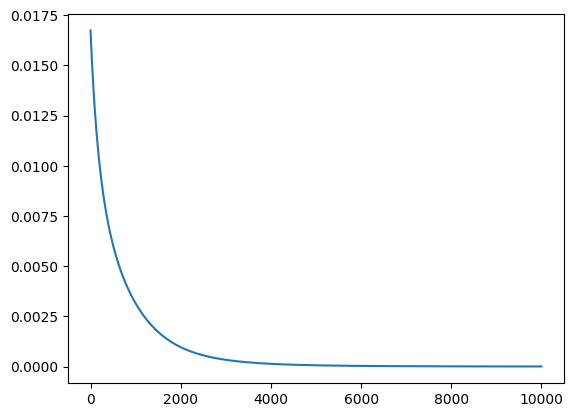

In [7]:
n1 = Neuron(2, Sigmoid())
all_E = []
for i in range(10000):
    for x, y in zip(X, Y):
        x = np.array(x)
        y = np.array(y)

        a = n1.forward(x)
        E = 0.5*(y - a)**2
        E_prime = (a - y)
        delta = n1.backward(E_prime, x)

        n1.update_weights()
    all_E += [E]

plt.figure()
plt.plot(all_E)
plt.show()

In [8]:
n0 = Neuron(2, Sigmoid())
n1 = Neuron(1, Sigmoid())
all_E = []
for i in range(100000):
    E = 0
    for x, y in zip(X, Y):
        x = np.array(x)
        y = np.array(y)

        a0 = n0.forward(x)
        a1 = n1.forward(a0)
        E += 0.5*(y - a1)**2
        E_prime = (a1 - y)
        d1 = n1.backward(E_prime, n0.a)
        d0 = n0.backward(d1, x)

    n1.update_weights()
    n0.update_weights()
    all_E += [E]

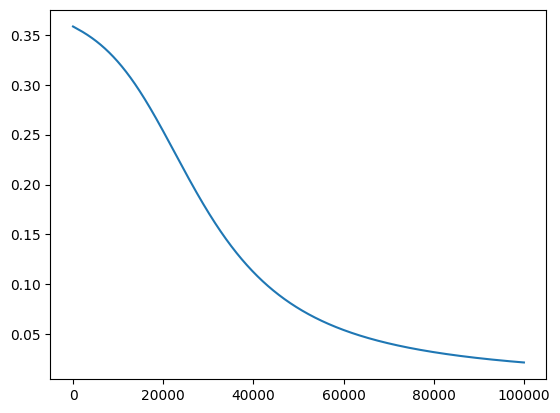

In [9]:
plt.figure()
plt.plot(all_E)
plt.show()

In [112]:
@dataclass
class Layer():
    num_neurons: int
    activation: ActivationFunction
    input_shape: np.ndarray = None
    neurons: List[Neuron] = None
    inputs: np.ndarray = None
    z: np.ndarray[float] = None
    a: np.ndarray[float] = None

    def __post_init__(self):
        if self.input_shape is not None:
            self.initialise_layer()

    def __call__(self, layer):
        self.input_shape = layer.num_neurons
        self.initialise_layer()
        return self
    
    def initialise_layer(self):
        self.neurons = [Neuron(self.input_shape, self.activation) for _ in range(self.num_neurons)]

    def forward(self, x):
        self.inputs = x
        for n in self.neurons: n.forward(x)
        self.z = [n.z for n in self.neurons]
        self.a = [n.a for n in self.neurons]
        return self.a
    
    def backward(self, error, previous_output, lp1 = None):
        [n.backward(error, p) for n, p in zip(self.neurons, previous_output)]
        if lp1 is not None:
            error = compute_error_term(self, lp1)
            return error

def compute_error_term(layer, layerp1):
    error = np.zeros(len(layer.neurons))
    for i in range(len(layer.neurons)):
        for j in range(len(layerp1.neurons)):
            error[i] += layerp1.neurons[j].weights[i] * layerp1.neurons[j].error # compute the dot product iteratively.
    
    return error

In [149]:
l0 = Layer(5, Sigmoid(), 2)
print(l0)
l1 = Layer(2, Sigmoid())(l0)
print(l1)
output = Layer(1, Sigmoid())(l1)
print(output)
#[n.backward(np.dot(np1.weights, np1.delta * np.ones_like(np1.weights)), a1) for n in l1.neurons for np1 in output.neurons]
#[n.backward(np.dot(np1.weights, np1.delta), a1) for n in l0.neurons for np1 in l1.neurons]
#print(output.neurons[0].delta)

Layer(num_neurons=5, activation=Sigmoid(name='sigmoid'), input_shape=2, neurons=[Neuron(input_shape=2, activation_function=Sigmoid(name='sigmoid'), weights=array([0.24896549, 0.39626351]), bias=0.4708249458755619, error=0, delta=array([], dtype=float64), delta_weights=array([], dtype=float64), z=None, a=None), Neuron(input_shape=2, activation_function=Sigmoid(name='sigmoid'), weights=array([0.16700482, 0.91192828]), bias=0.4708249458755619, error=0, delta=array([], dtype=float64), delta_weights=array([], dtype=float64), z=None, a=None), Neuron(input_shape=2, activation_function=Sigmoid(name='sigmoid'), weights=array([0.80398627, 0.05660291]), bias=0.4708249458755619, error=0, delta=array([], dtype=float64), delta_weights=array([], dtype=float64), z=None, a=None), Neuron(input_shape=2, activation_function=Sigmoid(name='sigmoid'), weights=array([0.09846558, 0.64231636]), bias=0.4708249458755619, error=0, delta=array([], dtype=float64), delta_weights=array([], dtype=float64), z=None, a=No

In [150]:
x = np.array([1, 0])
y = np.array([1])

a0 = l0.forward(x)
a1 = l1.forward(a0)
o = output.forward(a1)

E = 0.5*(y - o)**2
print(E)
E_prime = (o - y)

def compute_error_term(layer, layerp1):
    error = np.zeros(len(layer.neurons))
    for i in range(len(layer.neurons)):
        for j in range(len(layerp1.neurons)):
            error[i] += layerp1.neurons[j].weights[i] * layerp1.neurons[j].error # compute the dot product iteratively.
    
    return error

[0.01064704]


In [155]:
output.backward(E_prime, o)
compute_error_term(l1, output)

/var/folders/kv/lptqtxls4fxg1pdm65_wqqn80000gn/T/ipykernel_2583/2888661387.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error[i] += layerp1.neurons[j].weights[i] * layerp1.neurons[j].error # compute the dot product iteratively.


array([-0.01504998, -0.01049228])

In [107]:
[n.backward(E_prime, p) for n, p in zip(output.neurons, a1)]
error = compute_error_term(l1, output)
[n.backward(e, p) for n, e, p in zip(l1.neurons, error, a0)]
error = compute_error_term(l0, l1)
print(error)
[n.backward(e, p) for n, e, p in zip(l0.neurons, error, x)]

[-0.0048377  -0.02736617]
(2,)
[-0.00040715 -0.00124425 -0.0021262  -0.00044315 -0.00155764]


/var/folders/kv/lptqtxls4fxg1pdm65_wqqn80000gn/T/ipykernel_2583/2888661387.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error[i] += layerp1.neurons[j].weights[i] * layerp1.neurons[j].error # compute the dot product iteratively.


[-3.939304483307017e-05, -0.00016521656343585072]

In [87]:
print(l0.neurons[0].weights)
l0.neurons[0].update_weights()
print(l0.neurons[0].weights)

[0.42046685 0.0527003 ]
[0.42047177 0.05270523]


# Testing implementation

In [95]:
l0 = Layer(5, Sigmoid(), 2)
print(l0)
l1 = Layer(2, Sigmoid())(l0)
print(l1)
output = Layer(1, Sigmoid())(l1)
print(output)
#[n.backward(np.dot(np1.weights, np1.delta * np.ones_like(np1.weights)), a1) for n in l1.neurons for np1 in output.neurons]
#[n.backward(np.dot(np1.weights, np1.delta), a1) for n in l0.neurons for np1 in l1.neurons]
#print(output.neurons[0].delta)

Layer(num_neurons=5, activation=Sigmoid(name='sigmoid'), input_shape=2, neurons=[Neuron(input_shape=2, activation_function=Sigmoid(name='sigmoid'), weights=array([0.97534747, 0.65963233]), bias=0.4708249458755619, error=0, delta=array([], dtype=float64), delta_weights=array([], dtype=float64), z=None, a=None), Neuron(input_shape=2, activation_function=Sigmoid(name='sigmoid'), weights=array([0.76513656, 0.43999712]), bias=0.4708249458755619, error=0, delta=array([], dtype=float64), delta_weights=array([], dtype=float64), z=None, a=None), Neuron(input_shape=2, activation_function=Sigmoid(name='sigmoid'), weights=array([0.1809589 , 0.67750467]), bias=0.4708249458755619, error=0, delta=array([], dtype=float64), delta_weights=array([], dtype=float64), z=None, a=None), Neuron(input_shape=2, activation_function=Sigmoid(name='sigmoid'), weights=array([0.09907302, 0.84063786]), bias=0.4708249458755619, error=0, delta=array([], dtype=float64), delta_weights=array([], dtype=float64), z=None, a=No

In [102]:
all_E = []

for i in range(10000):
    for x, y in zip(X, Y):
        x = np.array(x)
        y = np.array(y)

        a0 = l0.forward(x)
        a1 = l1.forward(a0)
        o = output.forward(a1)

        E = 0.5*(y - o)**2
        all_E += [E[0]]
        E_prime = (o - y)

        output.backward(E_prime, a1)
        [n.backward(E_prime, p) for n, p in zip(output.neurons, a1)]
        error = compute_error_term(l1, output)
        [n.backward(e, p) for n, e, p in zip(l1.neurons, error, a0)]
        error = compute_error_term(l0, l1)
        [n.backward(e, p) for n, e, p in zip(l0.neurons, error, x)]

    # Update weights
    [n.update_weights for n in l0.neurons]
    [n.update_weights for n in l1.neurons]
    [n.update_weights for n in output.neurons]

/var/folders/kv/lptqtxls4fxg1pdm65_wqqn80000gn/T/ipykernel_2583/2888661387.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error[i] += layerp1.neurons[j].weights[i] * layerp1.neurons[j].error # compute the dot product iteratively.


In [103]:
all_E

[0.30981019317556063,
 0.021556889711451584,
 0.022070087464668528,
 0.021226128231831697,
 0.30981019317556063,
 0.021556889711451584,
 0.022070087464668528,
 0.021226128231831697,
 0.30981019317556063,
 0.021556889711451584,
 0.022070087464668528,
 0.021226128231831697,
 0.30981019317556063,
 0.021556889711451584,
 0.022070087464668528,
 0.021226128231831697,
 0.30981019317556063,
 0.021556889711451584,
 0.022070087464668528,
 0.021226128231831697,
 0.30981019317556063,
 0.021556889711451584,
 0.022070087464668528,
 0.021226128231831697,
 0.30981019317556063,
 0.021556889711451584,
 0.022070087464668528,
 0.021226128231831697,
 0.30981019317556063,
 0.021556889711451584,
 0.022070087464668528,
 0.021226128231831697,
 0.30981019317556063,
 0.021556889711451584,
 0.022070087464668528,
 0.021226128231831697,
 0.30981019317556063,
 0.021556889711451584,
 0.022070087464668528,
 0.021226128231831697,
 0.30981019317556063,
 0.021556889711451584,
 0.022070087464668528,
 0.021226128231831697,

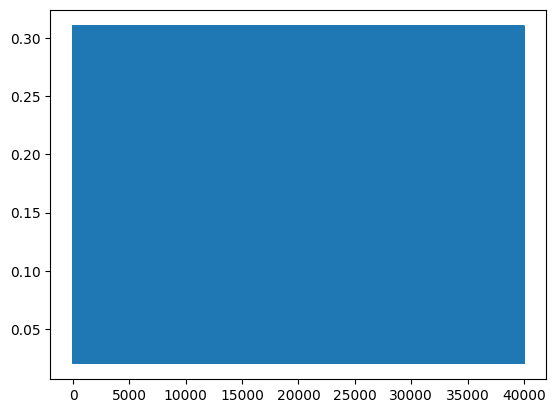

In [104]:
plt.figure()
plt.plot(all_E)
plt.show()